# Text Experiments
---
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
---
## Summary

Experiments for the text-only sentiment analysis models. We are trying the following models:
- [SVC](#svc)
- [Logistic Regression with Random Search](#logistic-regression-with-random-search)
- [Naive Bayes](#naive-bayes)
    - [Multinomial](#multinomial-nb)
    - [Complement](#complement-nb)
- [One vs. Rest](#one-vs-rest)
- [FFNN](#ffnn)
- [LSTM](#lstm)

For SVC, Logistic Regression, both Naive Bayes and FFNN (which will only accept string inputs and outputs) we will experiment with the following:
- Count Vectors
- TF-IDF Vectors
- Gensim Custom Doc2Vec Vectors

For LSTM
- Gensim word2vec Vectors via [GoogleNews](https://code.google.com/archive/p/word2vec/)
---
## Setup
### Necessary Imports
#### Experiment Class & Metrics

In [123]:
from experiment import (Experiment,
                        plot_confusion_matrix,
                        vectorizer, )

from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             confusion_matrix, )

#### Models

In [124]:
from neural import (FFNN,
                    LSTM, )
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import (MultinomialNB,
                                 ComplementNB, )
from sklearn.svm import SVC

from torch.nn import (Dropout,
                      Linear,
                      Softmax,
                      Tanh,
                      ReLU,
                      LeakyReLU, )

#### Other

In [125]:
from collections import OrderedDict
from gensim.models.doc2vec import Doc2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from nltk import word_tokenize
from nltk.corpus import stopwords
from scipy.stats import (uniform,
                         ttest_ind_from_stats, )
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer, )
from sklearn.model_selection import RandomizedSearchCV
from torch.utils.data import WeightedRandomSampler

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


### Global Variables & Settings

In [126]:
# Turn this off
%pprint
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

Pretty printing has been turned OFF


In [127]:
DATA_PATH = "../data/final-splits.csv"
DATA = pd.read_csv(DATA_PATH, index_col=False)
EMOTIONS = DATA.emotion.unique()

SEED = 42

METRICS = {"accuracy": (accuracy_score, {}),
           "precision_recall_fscore_support": (precision_recall_fscore_support, {"average": "macro", "zero_division": np.nan}),
           "confusion_matrix": (confusion_matrix, {"labels": EMOTIONS}), }

RESULTS = {"experiment": [],
           "accuracy": [],
           "precision": [],
           "recall": [],
           "fpr": [],
           "f1_score": [], 
           "comments": [], }

WTESTS = True  # Include and load word2vec experiments
DTESTS = True   # Include and load doc2vec experiments

# Only run the experiments listed here; empty means run all

targets = ["FFNN/D2V",] # "FFNN/D2VO", "FFNN/TFIDFO", "LSTM/W2VO"]
def selected(target):
    if target in targets or len(targets) == 0:
        if ("D2V" in target and not DTESTS) or ("W2V" in target and not WTESTS):
            return False
        return True
    return False

In [128]:
if WTESTS:

    WORD2VEC_PATH = "../data/word2vec/GoogleNews-vectors-negative300.bin"
    W2V: KeyedVectors = KeyedVectors.load_word2vec_format(WORD2VEC_PATH, binary=True)

if DTESTS:

    DOC2VEC_PATH = "../data/doc2vec-15-70.bin"
    D2V: Doc2Vec = Doc2Vec.load(DOC2VEC_PATH)

STOPWORDS = stopwords.words()

### Functions

In [129]:
def display_results(metrics, experiment, comments):

    print(f"Accuracy: {metrics['accuracy']:.3f}")
    
    prec, recall, f1, _ = metrics['precision_recall_fscore_support']

    print(f"Precision: {prec:.3f}")
    print(f"Recall: {recall:.3f}")

    conf: np.ndarray = metrics['confusion_matrix']

    def calc_fpr(i: int):

        tp = conf[i, i]
        fp = conf[:, i].sum() - tp
        fn = conf[i, :].sum() - tp
        tn = conf.sum() - fp - fn - tp

        return fp / (fp + tn)

    fpr = sum([calc_fpr(i) for i in range(len(EMOTIONS))]) / len(EMOTIONS)

    print(f"FPR: {fpr:.3f}")
    print(f"F1-Score: {f1:.3f}")

    plot_confusion_matrix(conf, labels=EMOTIONS)

    RESULTS['experiment'].append(experiment)
    RESULTS['accuracy'].append(metrics['accuracy'])
    RESULTS['precision'].append(prec)
    RESULTS['recall'].append(recall)
    RESULTS['fpr'].append(fpr)
    RESULTS['f1_score'].append(f1)
    RESULTS['comments'].append(comments)

In [130]:
def exp_run(name, model, transforms, list_kwargs = None, comments = "", **kwargs):

    exp = Experiment(name=name, data=DATA, model=model, comments=comments)

    if transforms:
        for i, transform in enumerate(transforms):
            exp.transform(transform, **(list_kwargs[i] if list_kwargs else {}))

    results = exp.full_run(metrics=METRICS, **kwargs)
    display_results(results, name, comments)

    return exp

In [131]:
MAX_FEATS = 5_000
def default_vector(name: str, max_features: int=MAX_FEATS):

    if name == "count":
        return CountVectorizer(stop_words="english", max_features=max_features)
    elif name == "tfidf":
        return TfidfVectorizer(stop_words="english", max_features=max_features) 

In [132]:
VEC_LEN = 25
def w2v_transform(X, y, subset, doc_len=VEC_LEN):
    '''
    Also pads to a fixed length
    '''
    pad = np.zeros(300, dtype=np.float32)
    sents = [simple_preprocess(sent)[:VEC_LEN] for sent in X]
    pad_w2vs = [[W2V[word] for word in sent if word in W2V.key_to_index.keys()] for sent in sents]

    for w2v in pad_w2vs:
        w2v.extend([pad] * (doc_len - len(w2v)))

    return pad_w2vs, y

In [133]:
def d2v_transform(X, y, subset):
    return [D2V.infer_vector(simple_preprocess(sent)) for sent in X], y

***
## SVC

In [134]:
EXP1A = "SVC/COUNT"

if selected(EXP1A):
    exp_run(EXP1A, model=SVC(C=1), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

In [135]:
EXP1B = "SVC/TFIDF"

if selected(EXP1B):
    exp_run(EXP1B, model=SVC(C=1), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

In [136]:
EXP1C = "SVC/D2V"

if selected(EXP1C):
    exp_run(EXP1C, model=SVC(C=1), transforms=[d2v_transform])

***
## Logistic Regression with Random Search

In [137]:
EXP2A = "LOG/COUNT"

if selected(EXP2A):

    distribution = {"C": uniform(),
                    "penalty": ["l1", "l2", "elasticnet"],
                    "l1_ratio": uniform(), }

    model = RandomizedSearchCV(estimator=LogisticRegression(solver="saga"), param_distributions=distribution, n_jobs=4, random_state=SEED)

    exp = exp_run(EXP2A, model=model, transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])
    print(exp.model.best_params_)

In [138]:
EXP2B = "LOG/TFIDF"

if selected(EXP2B):

    distribution = {"C": uniform(),
                    "penalty": ["l1", "l2", "elasticnet"],
                    "l1_ratio": uniform(), }
    
    model = RandomizedSearchCV(estimator=LogisticRegression(solver="saga"), param_distributions=distribution, n_jobs=4, random_state=SEED)

    exp = exp_run(EXP2B, model=model, transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])
    print(exp.model.best_params_)

In [139]:
EXP2C = "LOG/D2V"

if selected(EXP2C):

    distribution = {"C": uniform(),
                    "penalty": ["l1", "l2", "elasticnet"],
                    "l1_ratio": uniform(), }
    
    model = RandomizedSearchCV(estimator=LogisticRegression(solver="saga"), param_distributions=distribution, n_jobs=4, random_state=SEED)

    exp = exp_run(EXP2C, model=model, transforms=[d2v_transform])
    print(exp.model.best_params_)

***
## Naive Bayes
### Multinomial NB

In [140]:
EXP3A = "MNB/COUNT"

if selected(EXP3A):
    exp_run(EXP3A, model=MultinomialNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

In [141]:
EXP3B = "MNB/TFIDF"

if selected(EXP3B):
    exp_run(EXP3B, model=MultinomialNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

### Complement NB

In [142]:
EXP4A = "COM/COUNT"

if selected(EXP4A):
    exp_run(EXP4A, model=ComplementNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

In [143]:
EXP4B = "COM/TFIDF"

if selected(EXP4B):
    exp_run(EXP4B, model=ComplementNB(), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("tfidf")}])

***
## One Vs. Rest

For this, we will only run the best of the non-NN models.

In [144]:
EXP5A = "ONE"

if selected(EXP5A):
    exp_run(EXP5A, model=OneVsRestClassifier(MultinomialNB()), transforms=[vectorizer], list_kwargs=[{"vect": default_vector("count")}])

***
## FFNN

In [145]:
def plot_loss(loss_record):

    df = pd.DataFrame(loss_record)
    df['training'] = df['epoch'] + df['step']
    sns.lineplot(data=df, x='training', y='loss')

In [146]:
CAT_TO_ID = {cat: i for i, cat in enumerate(DATA["emotion"].unique())}
ID_TO_CAT = {CAT_TO_ID[cat]: cat for cat in CAT_TO_ID}

def cat_transform(X, y, subset):
    return X, np.array([CAT_TO_ID[cat] for cat in y], dtype=int)

def to_emotions(y_true, y_pred):
    return [ID_TO_CAT[i] for i in y_true], [ID_TO_CAT[i] for i in y_pred]

print(CAT_TO_ID)
print(ID_TO_CAT)

{'something else': 0, 'contentment': 1, 'excitement-amusement': 2, 'fear': 3, 'awe': 4, 'sadness': 5, 'disgust-anger': 6}
{0: 'something else', 1: 'contentment', 2: 'excitement-amusement', 3: 'fear', 4: 'awe', 5: 'sadness', 6: 'disgust-anger'}


In [147]:
# Sanity check
l1, l2 = [0,2,3,1,2,4,1,2,], [1,2,0,4,4,3,2]
assert cat_transform(X=None, y=to_emotions(l1, l2)[0], subset="TRAIN")[1].tolist() == l1
assert cat_transform(X=None, y=to_emotions(l1, l2)[1], subset="TRAIN")[1].tolist() == l2

In [148]:
numpy_transform = lambda X, y, subset: (np.array(X).astype(np.float32), y)
scipy_transform = lambda X, y, subset: (X.toarray().astype(np.float32), y)

In [149]:
weights = [0,0,0,0,0,0,0]
for k in CAT_TO_ID:
    weights[CAT_TO_ID[k]] = 1 / DATA[DATA['split'] == 'TRAIN'].emotion.value_counts()[k]**0.5

In [150]:
# Sanity check
assert sorted(weights, reverse=True) == \
(1 / DATA[DATA['split'] == 'TRAIN'].emotion.value_counts()**0.5) \
.sort_values(ascending=False).to_list()

In [153]:
# The model for all FFNN experiments
steps_tfidf = OrderedDict([("l1", Linear(MAX_FEATS, 50)),
                           ("a1", LeakyReLU()),
                           ("d1", Dropout(p=0.2)),
                           ("l2", Linear(50, 7)), ])

steps_d2v = OrderedDict([("l1", Linear(15, 15)),
                         ("a1", Softmax()),
                         ("d1", Dropout(p=0.2)),
                         ("l2", Linear(15, 7)), ])

sampler = WeightedRandomSampler(weights,
                                len(DATA[DATA['split'] == "TRAIN"]),
                                replacement=True)

config = {"steps": None,
          "lr": 1E-4,
          "epochs": 50,
          "batch_size": 4,
          "binary": False, 
          "sampler": None, }

Accuracy: 0.174
Precision: 0.165
Recall: 0.150
FPR: 0.142
F1-Score: 0.169


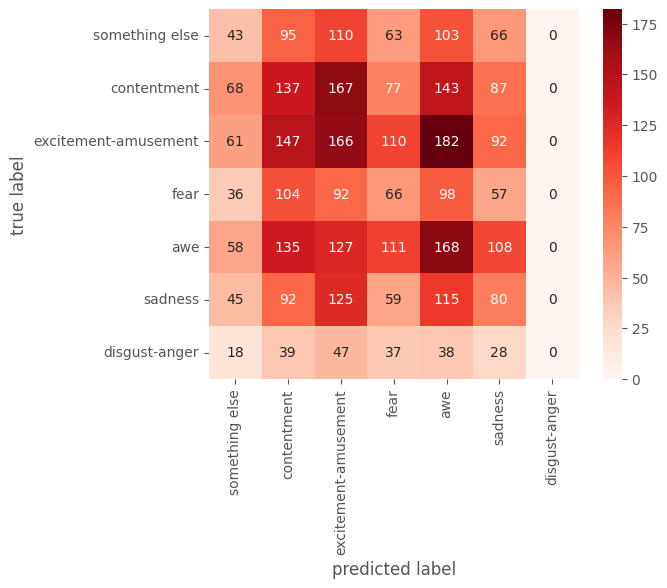

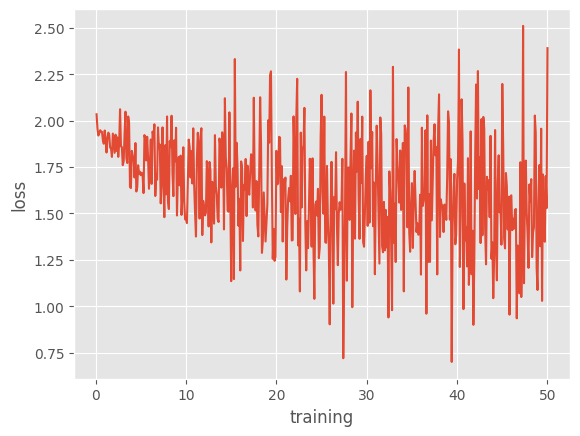

In [154]:
EXP6A = "FFNN/D2V"

if selected(EXP6A):

    config['steps'] = steps_d2v

    exp = exp_run(EXP6A, model=FFNN(**config), 
                  transforms=[d2v_transform, cat_transform, numpy_transform], 
                  verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

Accuracy: 0.163
Precision: 0.157
Recall: 0.141
FPR: 0.143
F1-Score: 0.160


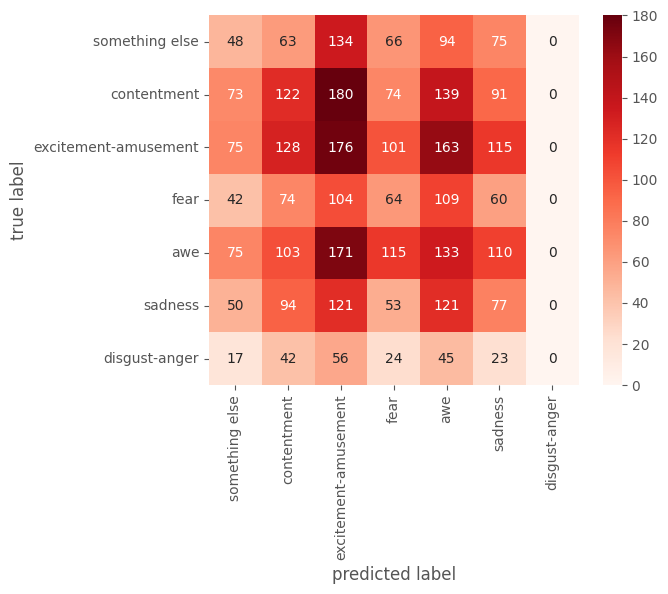

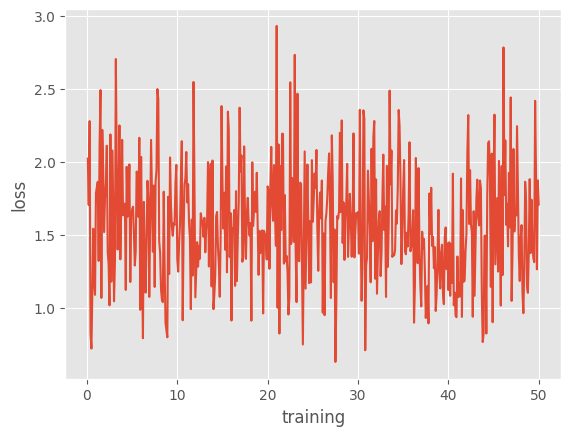

In [ ]:
EXP6B = "FFNN/D2VO"

if selected(EXP6B):

    config['steps'] = steps_d2v

    exp = exp_run(EXP6B, model=FFNN(**config), transforms=[d2v_transform, cat_transform, numpy_transform], verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

Accuracy: 0.171
Precision: 0.161
Recall: 0.146
FPR: 0.142
F1-Score: 0.166


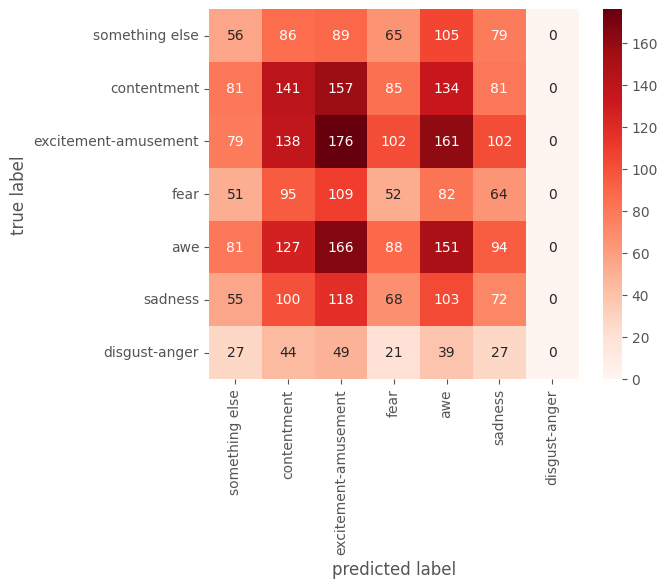

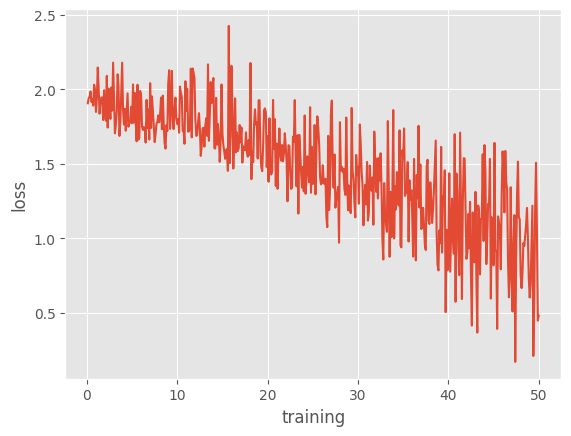

In [ ]:
EXP6C = "FFNN/TFIDFO"

if selected(EXP6C):

    config['steps'] = steps_tfidf

    exp = exp_run(EXP6C, model=FFNN(**config), 
                  transforms=[vectorizer, cat_transform, scipy_transform], 
                  list_kwargs=[{"vect": default_vector("tfidf")}, {}, {}], 
                  verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

---

## LSTM

In [ ]:
EXP7A = "LSTM/W2VO"

if selected(EXP7A):

    def to_emotions(y_true, y_pred):
        return [ID_TO_CAT[i] for i in y_true], [ID_TO_CAT[i] for i in y_pred]

    numpy_transform = lambda X, y, subset: (np.array(X).astype(np.float32), y)

    sampler = WeightedRandomSampler(weights,
                                    len(DATA[DATA['split'] == "TRAIN"]),
                                    replacement=True)

    config = {"input_size": 300,
              "hidden_size": 40,
              "num_layers": 20,
              "num_classes": 7,
              "lr": 1E-2,
              "epochs": 100,
              "batch_size": 16,
              "binary": False, 
              "sampler": sampler, }

    exp = exp_run(EXP6C, model=LSTM(**config), 
                  transforms=[w2v_transform, cat_transform, numpy_transform], 
                  verbose=False, post=to_emotions)
    plot_loss(exp.model.loss_record)

KeyboardInterrupt: 

***
## Results

In [ ]:
results_df = pd.DataFrame(RESULTS)
results_df["ratio"] = results_df["recall"] / results_df["fpr"]
results_df

,experiment,accuracy,precision,recall,fpr,f1_score,comments,ratio
0,FFNN/D2V,0.161579,0.157388,0.152546,0.141739,0.162000,,1.076245
1,FFNN/D2VO,0.148947,0.144532,0.136516,0.143893,0.146819,,0.948731
2,FFNN/TFIDFO,0.087895,0.142297,0.137009,0.143540,0.090673,,0.954500
3,FFNN/TFIDFO,0.178684,0.178684,0.142857,0.142857,0.303193,,1.000000


In [ ]:
DATA['emotion'].value_counts().describe()

count       7.000000
mean     2714.285714
std       951.446918
min      1035.000000
25%      2333.500000
50%      2579.000000
75%      3464.000000
max      3791.000000
Name: count, dtype: float64

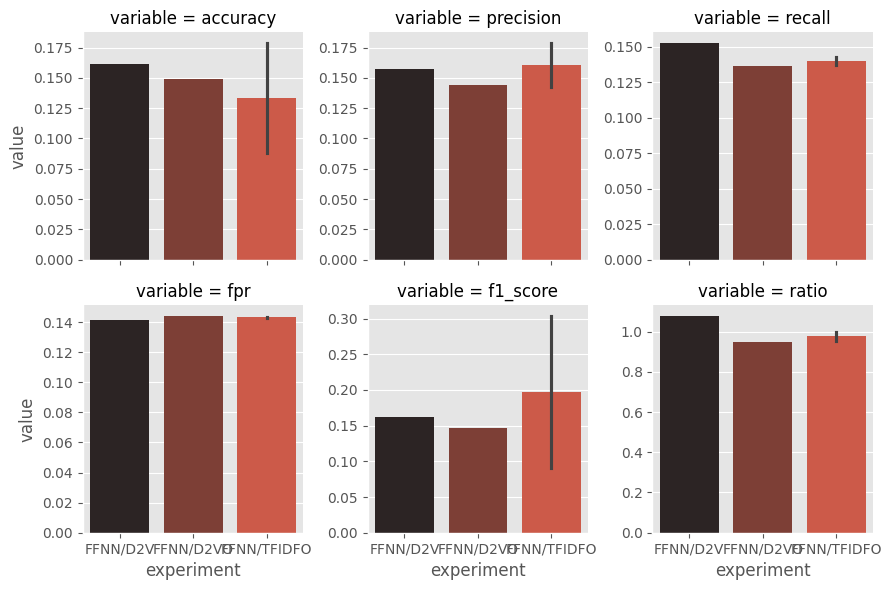

In [ ]:
grid = sns.FacetGrid(data=results_df.drop(columns=["comments"]).melt(id_vars=["experiment"]),
                     col="variable", col_wrap=3, sharey=False)
grid.map_dataframe(sns.barplot, x="experiment", y="value", hue="experiment")
